In [1]:
import pandas as pd
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
def get_shot_data(shot):
    from toksearch_d3d import PtDataSignal
    x=PtDataSignal('CKXOUT').fetch(shot)
    data = x['data']
    NYMODEL = 2
    NYOUT_PTS = 101
    NYPROF = 7

    prof_data = data.reshape((-1, NYMODEL, NYOUT_PTS, NYPROF))

    dens_profiles = prof_data[:, 1, :, 3]  # 3-- for density || 6 for rotation
    rot_profiles = prof_data[:, 1, :, 6]
    q_profiles = prof_data[:, 1, :, 2]
    pres_profiles = prof_data[:, 1, :, 0]
    etemp_profiles = prof_data[:, 1, :, 4]
    
    return dens_profiles, rot_profiles, pres_profiles, etemp_profiles

In [32]:
shot_dens, shot_rot, shot_pres, shot_etemp = get_shot_data(203016)
shot_dens.shape, shot_rot.shape, shot_pres.shape, shot_etemp.shape

Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.


((345, 101), (345, 101), (345, 101), (345, 101))

#### Profile down-sampling

In [3]:
import numpy as np

def kToolMath_interp_numpy(psi_in: np.ndarray, x_in: np.ndarray, out_size: int) -> np.ndarray:
    """
    NumPy equivalent of kToolMath_interp when:
      psi_in = np.linspace(0, 1, 101) and x_in has length 101.

    Builds psi_out = linspace(0,1,out_size) and returns interpolated values.
    """
    x_in = np.asarray(x_in, dtype=np.float32)
    psi_in = np.asarray(psi_in, dtype=np.float32)
    if x_in.ndim != 1:
        raise ValueError("x_in must be 1D")
    n = x_in.shape[0]
    if n < 2:
        raise ValueError("x_in must have length >= 2")
    if out_size <= 0:
        return np.empty((0,), dtype=np.float32)

    # psi_in is uniform in [0,1] with n points
    # Map psi_out points to fractional index positions t in [0, n-1]
    if out_size == 1:
        # matches C's psiOut[0] = 0/(out_size-1) behavior conceptually
        t = np.array([0.0], dtype=np.float32)
    else:
        psi_out = np.linspace(0.0, 1.0, out_size, dtype=np.float32)
        t = psi_out * (n - 1)

    i0 = np.floor(t).astype(np.int64)
    i1 = np.minimum(i0 + 1, n - 1)
    w = (t - i0).astype(np.float32)

    # Linear interpolation
    out = (1.0 - w) * x_in[i0] + w * x_in[i1]
    return out.astype(np.float32)


def kToolMath_interpFull_numpy(psi_in: np.ndarray,
                               x_in: np.ndarray,
                               psi_out: np.ndarray) -> np.ndarray:
    """
    Generic NumPy version *for this monotonic grid case*.
    Since psi_in is linspace(0,1,n), this reduces to the same fixed-grid mapping.

    Note: if psi_out goes outside [0,1], the C code does a wrap-around style
    interpolation across the endpoints; this implementation matches that by
    wrapping psi_out modulo 1.
    """
    psi_in = np.asarray(psi_in, dtype=np.float32)
    x_in = np.asarray(x_in, dtype=np.float32)
    psi_out = np.asarray(psi_out, dtype=np.float32)

    if psi_in.ndim != 1 or x_in.ndim != 1 or psi_out.ndim != 1:
        raise ValueError("psi_in, x_in, psi_out must be 1D")
    if psi_in.shape[0] != x_in.shape[0]:
        raise ValueError("psi_in and x_in must have the same length")
    n = psi_in.shape[0]
    if n < 2:
        raise ValueError("psi_in/x_in must have length >= 2")

    # If you truly only ever use psi_in = linspace(0,1,n), you can ignore psi_in values.
    # Handle wrap-around like the C code effectively does when outside bounds.
    psi = np.mod(psi_out, 1.0).astype(np.float32)  # wrap to [0,1)
    # Special-case exactly 1.0 (mod gives 0); map it back to 1.0 so endpoint works nicely
    psi = np.where(psi_out == 1.0, 1.0, psi).astype(np.float32)

    t = psi * (n - 1)
    i0 = np.floor(t).astype(np.int64)
    i1 = np.minimum(i0 + 1, n - 1)
    w = (t - i0).astype(np.float32)

    return ((1.0 - w) * x_in[i0] + w * x_in[i1]).astype(np.float32)

In [34]:
psi_in = np.linspace(0, 1, 101)
out_size = 33
kToolMath_interp_numpy(psi_in, shot_dens[75], out_size)

array([4.8662663, 4.7353506, 4.654067 , 4.595779 , 4.5096073, 4.4259186,
       4.3948874, 4.346697 , 4.2687864, 4.225126 , 4.208667 , 4.176136 ,
       4.1049395, 4.021708 , 3.9523365, 3.8947332, 3.8488028, 3.8178627,
       3.7671518, 3.6912045, 3.6227589, 3.540177 , 3.480742 , 3.4245079,
       3.3732674, 3.2986312, 3.213188 , 3.1536162, 3.0363855, 2.9090295,
       2.6817198, 2.1038146, 1.3407305], dtype=float32)

In [35]:
psi_in

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

#### Load RTCAKENN data

In [4]:
# Gathering all profiles
# shot_set = [203016, 203017, 203018, 203019, 203020, 203021, 203022, 203023, 203024, 203025, 203026, 203027, 203028, 203029]
shot_set = [i for i in range(203000, 204000)]
sorted_rot_profiles = []
sorted_dens_profiles = []
sorted_etemp_profile = []
sorted_pres_profile = []

for shot in shot_set:
    try:
        shot_dens, shot_rot, shot_pres, shot_etemp = get_shot_data(shot)
    except:
        continue
    for time_idx in range(len(shot_dens)):
        interp_dens = kToolMath_interp_numpy(np.linspace(0, 1, 101), shot_dens[time_idx], 33)
        interp_rot = kToolMath_interp_numpy(np.linspace(0, 1, 101), shot_rot[time_idx], 33)
        interp_etemp = kToolMath_interp_numpy(np.linspace(0, 1, 101), shot_etemp[time_idx], 33)
        interp_pres = kToolMath_interp_numpy(np.linspace(0, 1, 101), shot_pres[time_idx], 33)
        
        sorted_dens_profiles.append(interp_dens)
        sorted_rot_profiles.append(interp_rot)
        sorted_etemp_profile.append(interp_etemp)
        sorted_pres_profile.append(interp_pres)
sorted_dens_profiles = np.array(sorted_dens_profiles)
sorted_rot_profiles = np.array(sorted_rot_profiles)
sorted_etemp_profile = np.array(sorted_etemp_profile)
sorted_pres_profile = np.array(sorted_pres_profile)

sorted_dens_profiles.shape, sorted_rot_profiles.shape, sorted_etemp_profile.shape, sorted_pres_profile.shape

  The MDSplus python module version (HEAD_release_7.139.59) does not match
  the version of the installed MDSplus libraries (unknown_release_0.0.0).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment variable TOKSEARCH_INDEX_DIR not set.
Environment 

((8726, 33), (8726, 33), (8726, 33), (8726, 33))

In [5]:
def save_profile_to_template2(rot_profile=None, dens_profile=None, etemp_profile=None, pres_profile=None, filename='profiles.txt', dim = 33):
    """
    Save 4 profiles to a file in matrix format.
    
    Parameters:
    -----------
    rot_profile : array-like, optional
        Rotation profile (should be 33 dimensions). Default is array of 33 zeros.
    dens_profile : array-like, optional
        Density profile (should be 33 dimensions). Default is array of 33 zeros.
    etemp_profile : array-like, optional
        Electron temperature profile (should be 33 dimensions). Default is array of 33 zeros.
    pres_profile : array-like, optional
        Pressure profile (should be 33 dimensions). Default is array of 33 zeros.
    filename : str
        Output filename (e.g., 'my_profiles.txt')
    """
    # Set defaults if not provided
    if rot_profile is None:
        rot_profile = np.zeros(dim)
    if dens_profile is None:
        dens_profile = np.zeros(dim)
    if etemp_profile is None:
        etemp_profile = np.zeros(dim)
    if pres_profile is None:
        pres_profile = np.zeros(dim)
    # Ensure profiles are numpy arrays
    rot_profile = np.array(rot_profile)
    dens_profile = np.array(dens_profile)
    etemp_profile = np.array(etemp_profile)
    pres_profile = np.array(pres_profile)
    
    # Number of columns (assuming 33)
    n_cols = len(rot_profile)
    
    # Generate column names: 'col 0', 'col 1', ..., 'col 32'
    col_names = '|'.join([f'col {i}' for i in range(n_cols)])
    
    # Row names
    row_names = '|'.join(['rot', 'ne', 'te', 'pres'])
    
    # Write to file
    with open(filename, 'w') as f:
        # Write column name header
        f.write(f'COL_NAMES=|{col_names}\n')
        
        # Write row names header
        f.write(f'ROW_NAMES=|{row_names}\n')
        
        # Write each profile as a row
        profiles = [rot_profile, dens_profile, etemp_profile, pres_profile]
        for profile in profiles:
            row_values = ''.join([f'{value:12.2f}' for value in profile])
            f.write(f'{row_values}\n')
    
    print(f"Profiles saved to {filename}")

#### Profile targets selection

In [25]:
import numpy as np

def select_diverse_profiles_no_outliers(
    X: np.ndarray,
    N: int = 20,
    seed: int = 0,
    standardize: bool = True,
    outlier_frac: float = 0.02,          # exclude top 2% most extreme points
    outlier_metric: str = "l2",          # "l2" or "robust_l2"
    start: str = "maxnorm",              # "maxnorm" or "random"
):
    """
    Select N diverse profiles using farthest-point sampling (greedy k-center),
    while avoiding extreme outliers, then sort selected profiles by X[:,0] desc.

    Parameters
    ----------
    X : (n,d) array
    N : number to select
    outlier_frac : fraction of most extreme points to exclude (0.0 to <1.0)
    outlier_metric :
        - "l2": distance from mean in standardized space
        - "robust_l2": distance from median in standardized space (more robust)
    start :
        - "maxnorm": start farthest from center among the non-outliers
        - "random": random start among the non-outliers

    Returns
    -------
    selected_X : (N,d) array, sorted by descending X[:,0]
    selected_idx : (N,) indices into original X, in the same order
    keep_mask : (n,) boolean mask of points considered non-outliers
    """
    X = np.asarray(X, dtype=np.float64)
    if X.ndim != 2:
        raise ValueError("X must be 2D (n,d)")
    n, d = X.shape
    if not (1 <= N <= n):
        raise ValueError(f"N must be in [1, {n}]")
    if not (0.0 <= outlier_frac < 1.0):
        raise ValueError("outlier_frac must be in [0, 1)")

    # ---- standardize for distance computations ----
    Y = X
    if standardize:
        mu = Y.mean(axis=0)
        std = Y.std(axis=0, ddof=0)
        std[std == 0] = 1.0
        Y = (Y - mu) / std

    # ---- compute outlier score ----
    if outlier_metric == "l2":
        center = Y.mean(axis=0)
    elif outlier_metric == "robust_l2":
        center = np.median(Y, axis=0)
    else:
        raise ValueError("outlier_metric must be 'l2' or 'robust_l2'")

    score = np.sqrt(np.sum((Y - center) ** 2, axis=1))  # Euclidean norm

    # ---- build non-outlier mask ----
    if outlier_frac > 0:
        thresh = np.quantile(score, 1.0 - outlier_frac)
        keep_mask = score <= thresh
    else:
        keep_mask = np.ones(n, dtype=bool)

    keep_idx = np.flatnonzero(keep_mask)
    if keep_idx.size < N:
        raise ValueError(
            f"After excluding outliers, only {keep_idx.size} points remain < N={N}. "
            f"Reduce outlier_frac."
        )

    Yk = Y[keep_idx]

    rng = np.random.default_rng(seed)

    # ---- choose starting point among kept points ----
    if start == "random":
        first_local = int(rng.integers(0, Yk.shape[0]))
    elif start == "maxnorm":
        center_k = Yk.mean(axis=0)
        first_local = int(np.argmax(np.sum((Yk - center_k) ** 2, axis=1)))
    else:
        raise ValueError("start must be 'maxnorm' or 'random'")

    # ---- farthest-point sampling on kept set ----
    selected_local = np.empty(N, dtype=np.int64)
    selected_local[0] = first_local

    diff = Yk - Yk[first_local]
    min_dist2 = np.sum(diff * diff, axis=1)
    min_dist2[first_local] = 0.0

    for t in range(1, N):
        nxt = int(np.argmax(min_dist2))
        selected_local[t] = nxt

        diff = Yk - Yk[nxt]
        dist2 = np.sum(diff * diff, axis=1)
        min_dist2 = np.minimum(min_dist2, dist2)
        min_dist2[nxt] = 0.0

    # map back to original indices
    selected_idx = keep_idx[selected_local]
    selected_X = X[selected_idx]

    # ---- sort selected by zeroth dimension ascending ----
    order = np.argsort(selected_X[:, 0])
    selected_X = selected_X[order]
    selected_idx = selected_idx[order]

    return selected_X, selected_idx, keep_mask

In [ ]:
#selected_dens, _, _ = select_diverse_profiles_no_outliers(sorted_dens_profiles, 40, seed=601, outlier_frac=0.05)
#selected_rot, _, _ = select_diverse_profiles_no_outliers(sorted_rot_profiles, 40, seed=601, outlier_frac=0.05)
#selected_etemp, _, _ = select_diverse_profiles_no_outliers(sorted_etemp_profile, 40, seed=601, outlier_frac=0.05)
#selected_pres, _, _ = select_diverse_profiles_no_outliers(sorted_pres_profile, 40, seed=601, outlier_frac=0.05)

#### Target visualization

15

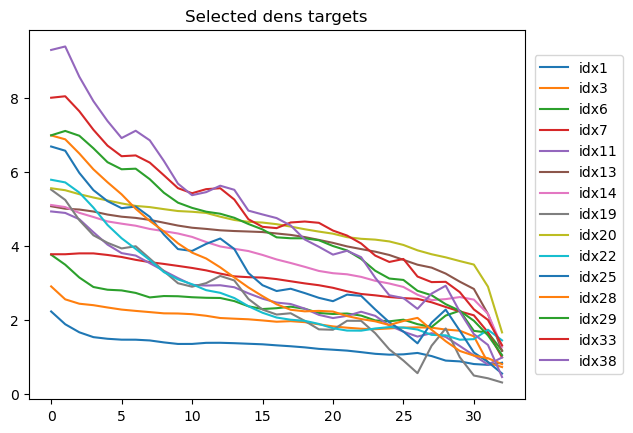

In [232]:
idxs_dens = [1, 3, 6, 7, 11, 13, 14, 19, 20, 22, 25, 28, 29, 33, 38]
for idx in idxs_dens:
    plt.plot(selected_dens[idx], label=f'idx{idx}')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.title("Selected dens targets")
len(idxs_dens)

15

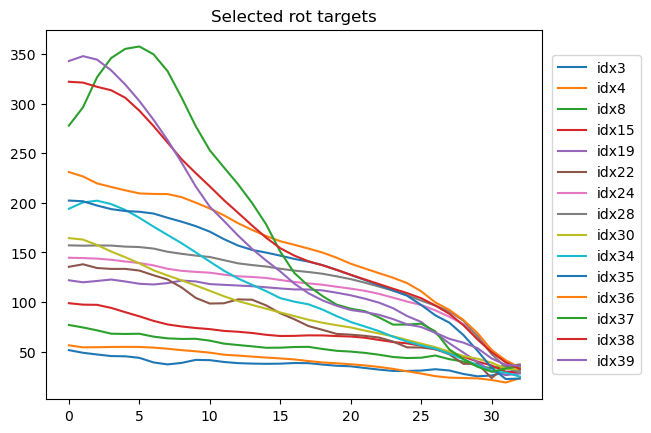

In [233]:
idxs_rot = [3, 4, 8, 15, 19, 22, 24, 28, 30, 34, 35, 36, 37, 38, 39]
for idx in idxs_rot:
    plt.plot(selected_rot[idx], label=f'idx{idx}')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.title("Selected rot targets")
len(idxs_rot)

15

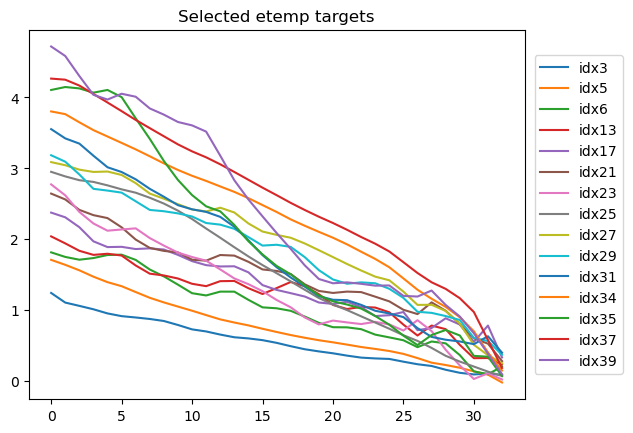

In [234]:
idxs_etemp = [3, 5, 6, 13, 17, 21, 23, 25, 27, 29, 31, 34, 35, 37, 39]
for idx in idxs_etemp:
    plt.plot(selected_etemp[idx], label=f'idx{idx}')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.title("Selected etemp targets")
len(idxs_etemp)

15

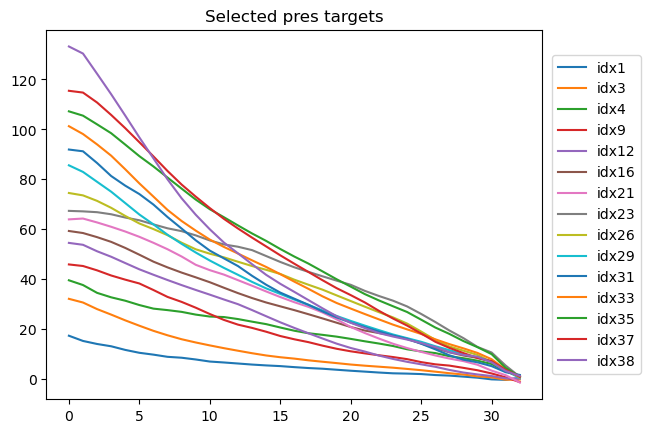

In [235]:
idxs_pres = [1, 3, 4, 9, 12, 16, 21, 23, 26, 29, 31, 33, 35, 37, 38]
for idx in idxs_pres:
    plt.plot(selected_pres[idx], label=f'idx{idx}')
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
plt.title("Selected pres targets")
len(idxs_pres)

#### Save targets to txt

In [236]:
def save_profile_to_template2(rot_profile=None, dens_profile=None, etemp_profile=None, pres_profile=None, filename='profiles.txt', dim = 33):
    """
    Save 4 profiles to a file in matrix format.
    
    Parameters:
    -----------
    rot_profile : array-like, optional
        Rotation profile (should be 33 dimensions). Default is array of 33 zeros.
    dens_profile : array-like, optional
        Density profile (should be 33 dimensions). Default is array of 33 zeros.
    etemp_profile : array-like, optional
        Electron temperature profile (should be 33 dimensions). Default is array of 33 zeros.
    pres_profile : array-like, optional
        Pressure profile (should be 33 dimensions). Default is array of 33 zeros.
    filename : str
        Output filename (e.g., 'my_profiles.txt')
    """
    # Set defaults if not provided
    if rot_profile is None:
        rot_profile = np.zeros(dim)
    if dens_profile is None:
        dens_profile = np.zeros(dim)
    if etemp_profile is None:
        etemp_profile = np.zeros(dim)
    if pres_profile is None:
        pres_profile = np.zeros(dim)
    # Ensure profiles are numpy arrays
    rot_profile = np.array(rot_profile)
    dens_profile = np.array(dens_profile)
    etemp_profile = np.array(etemp_profile)
    pres_profile = np.array(pres_profile)
    
    # Number of columns (assuming 33)
    n_cols = len(rot_profile)
    
    # Generate column names: 'col 0', 'col 1', ..., 'col 32'
    col_names = '|'.join([f'col {i}' for i in range(n_cols)])
    
    # Row names
    row_names = '|'.join(['rot', 'ne', 'te', 'pres'])
    
    # Write to file
    with open(filename, 'w') as f:
        # Write column name header
        f.write(f'COL_NAMES=|{col_names}\n')
        
        # Write row names header
        f.write(f'ROW_NAMES=|{row_names}\n')
        
        # Write each profile as a row
        profiles = [rot_profile, dens_profile, etemp_profile, pres_profile]
        for profile in profiles:
            row_values = ''.join([f'{value:12.2f}' for value in profile])
            f.write(f'{row_values}\n')
    
    print(f"Profiles saved to {filename}")

In [237]:
# Save it
for idx in range(15):
    save_profile_to_template2(rot_profile = selected_rot[idxs_rot[idx]],
                              dens_profile= selected_dens[idxs_dens[idx]],
                              etemp_profile= selected_etemp[idxs_etemp[idx]],
                              pres_profile= selected_pres[idxs_pres[idx]], 
                              filename=f'/home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T{idx+1}.txt')


Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T1.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T2.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T3.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T4.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T5.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T6.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T7.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T8.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T9.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T10.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T11.txt
Profiles saved to /home/hux/rl_prof_control_exp/jan_26_exp/selected_targets/T12.txt
P